### TSNE visualization of Binance exchange rates

Data preprocessing

In [12]:
import pandas as pd 
df=pd.read_hdf('Binance_eth_btc_big.h5')
#df.head(100)

In [13]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [14]:
Close = df['close'][20:-50]
Open = df['open'][20:-50]
High = df['high']
Low = df['low']
Vol = df['volume']
Timestamp = df['begin'][20:-50]

In [15]:
ndays=len(Close)//60
Close=np.array(Close)
Timestamp = np.array(Timestamp)

Combine per second data into per minute

In [16]:
minClose = [Close[60*i] for i in range(ndays)]
#minOpen = [Open[60*i] for i in range(ndays)]
Mins = [Timestamp[60*i] for i in range(ndays)]
#Mins,minClose

In [17]:
minClose=minClose[::-1]
Mins = Mins[::-1]

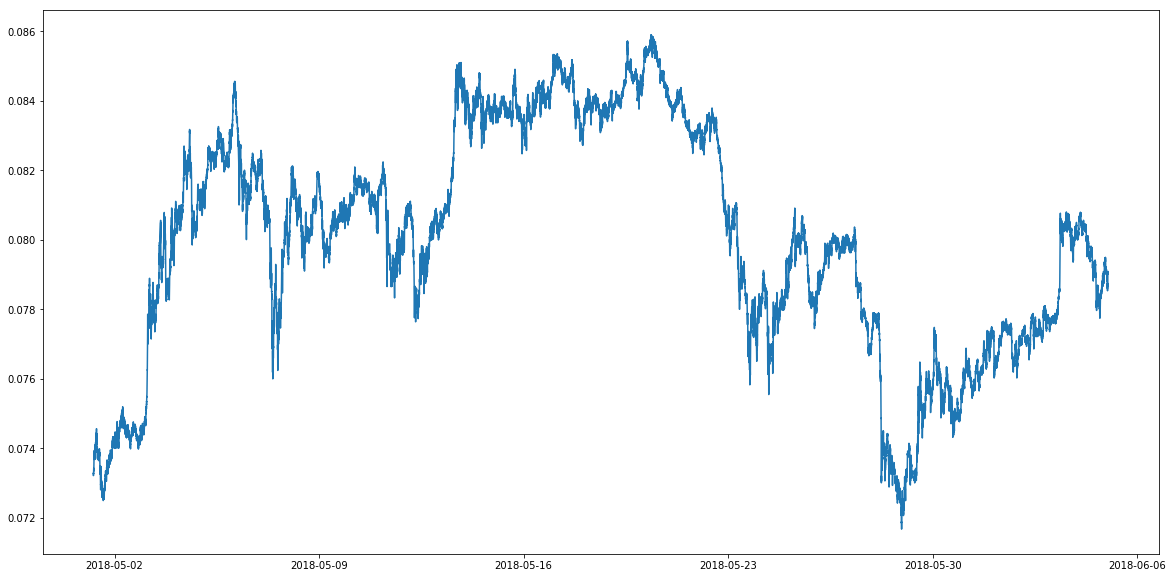

In [18]:
plt.figure(figsize=(20,10))
plt.plot(Mins,minClose)

In [19]:
len(minClose)

49998

# t-SNE applied to time series data

Currently, tSNE is run with correlation as the metric, other metric such as euclidean an DTW can also be tried.

Test 1 eth-btc

In [20]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
def dtw(X,Y):
    distance, path = fastdtw(X, Y, dist=euclidean)
    return distance

The window size is 240 minutes with no overlapping between segments.

In [21]:
X = []
window=240
for i in range(int(len(minClose)/window)):
    
    x=list(minClose[i*window:i*window+window]/minClose[i*window])
    X.append(np.array(x))
len(X),len(X[0])

(208, 240)

In [49]:
import numpy as np
np.random.seed(0)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,verbose=1,metric='correlation').fit_transform(X)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.000s...
[t-SNE] Computed neighbors for 208 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.286857
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.343933
[t-SNE] Error after 950 iterations: 0.502452


(208, 2)

The resulting tSNE plot in 2D is shown below, we then do a simple kmeans clustering using some arbitrarily set cluster number and map each clusters to the original dataset.

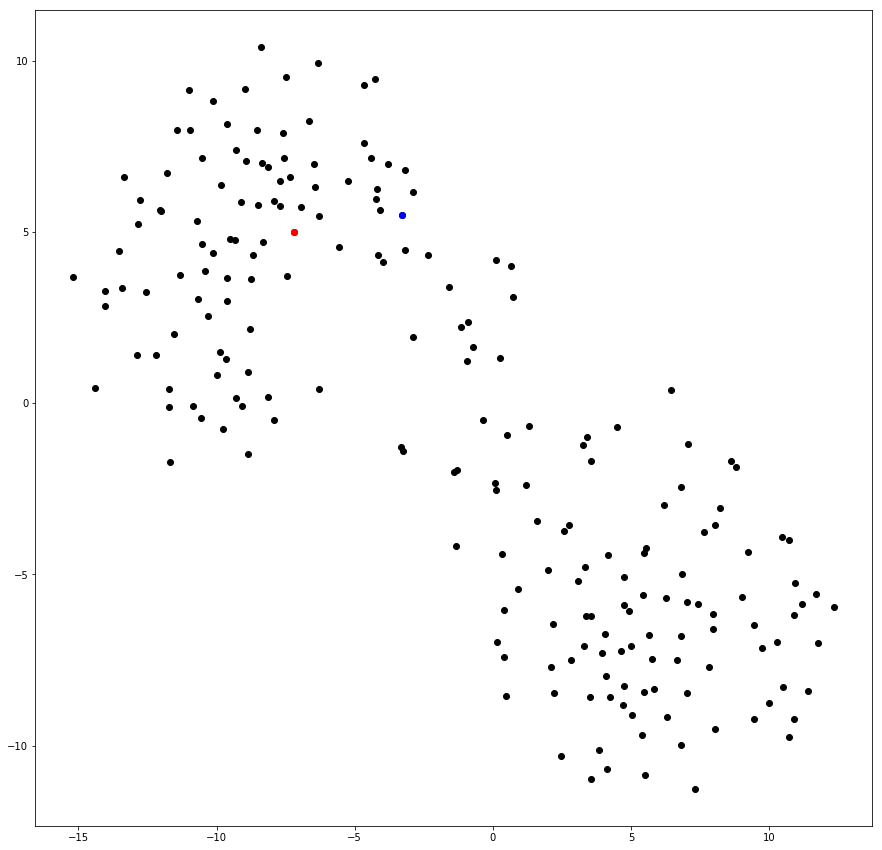

In [50]:
plt.figure(figsize=(15,15))
xx = X_embedded[:,0]
yy = X_embedded[:,1]
plt.plot(xx,yy,'ko')
plt.plot(xx[0],yy[0],'bo')
plt.plot(xx[-1],yy[-1],'ro')


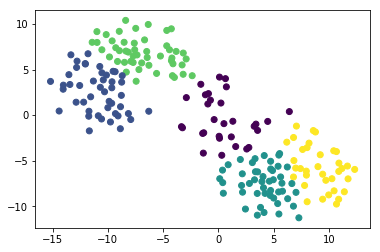

In [51]:
from sklearn.cluster import KMeans
np.random.seed(100)
kmeans = KMeans(n_clusters=5, random_state=10).fit(X_embedded)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=kmeans.labels_)

In [52]:
len(X),len(kmeans.labels_)

(208, 208)

In [53]:
label = []
for i in kmeans.labels_:
    label+=[i]*window
#label

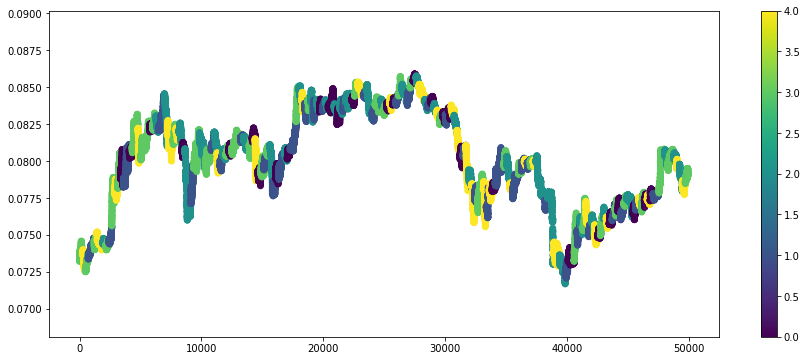

In [54]:
plt.figure(figsize=(15,6))
plt.ylim((min(minClose)*0.95,max(minClose)*1.05))
plt.scatter(range(len(X_embedded)*window),minClose[:len(X_embedded)*window],c=label)
plt.colorbar()

In [55]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')

Combine up trends into a single trend, down trends into a single trend, and oscillating states into a single trend.

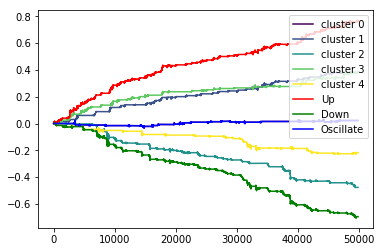

In [56]:
Seg = []
Cur = []
u = np.zeros(len(X_embedded)*window+1)
d = np.zeros(len(X_embedded)*window+1)
o = np.zeros(len(X_embedded)*window+1)
us = []
ds = []
os=  []
for j in range(5):
    cur = [0]
    seg = 0
    flag= False
    for i in range(len(X_embedded)*window):
        ret = minClose[i+1]*1.0/minClose[i]-1
        if label[i] == j:
            if not flag:
                seg+=1
                flag = True
            cur.append(cur[-1]+ret)
        else:
            if flag:
                flag=False
            cur.append(cur[-1])
    Cur.append(cur)
    Seg.append(seg)
    plt.plot(cur,c=cmap(j/4.0),label='cluster '+str(j))
Cur = np.array(Cur)
end = Cur[:,-1]
for i in range(5):
    if end[i]>=0.2*max(end):
        u+=Cur[i]
        us.append(i)
    elif end[i]<=0.2*min(end):
        d+=Cur[i]
        ds.append(i)
    else:
        o+=Cur[i]
        os.append(i)
plt.plot(u,'r',label='Up')
plt.plot(d,'g',label='Down')
plt.plot(o,'b',label='Oscillate')
plt.legend()

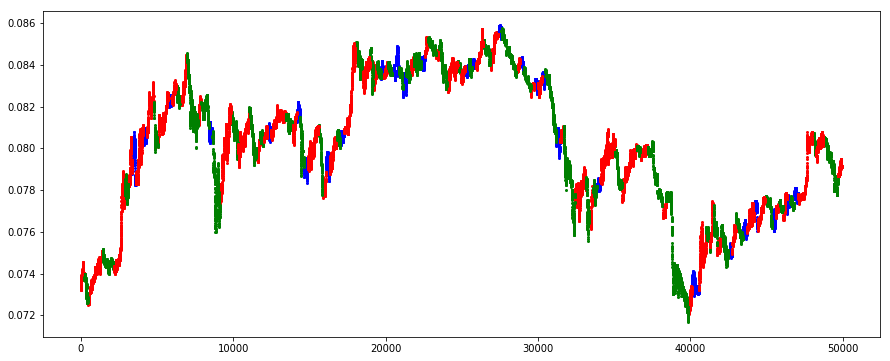

In [57]:
plt.figure(figsize=(15,6))
score_up = 0
score_down = 0
score_none = 0
tseg = sum(Seg)
fee=0.005
Mins=np.arange(len(X_embedded)*window)
Close=np.array(minClose[:len(X_embedded)*window])
Z=np.array(label)
for i in range(5):
    
    if i in os:
        score_none+=end[i]
        plt.plot(Mins[Z==i],Close[Z==i],'bo',markersize=2)
    elif i in us:
        score_up+=end[i]-fee*Seg[i]
        plt.plot(Mins[Z==i],Close[Z==i],'ro',markersize=2)
    else:
        score_down+=abs(end[i])-fee*Seg[i]
        plt.plot(Mins[Z==i],Close[Z==i],'go',markersize=2)

Score based on trading profit from long and short trades minus the missing profits from oscillating states, subtracting the transaction fees.

In [58]:
print('Score:'+str(score_up+score_down-abs(score_none)))

Score:0.7278708113320866


Test 2 zrx-btc

In [22]:
df=pd.read_hdf('Binance_zrx_btc.h5')

In [23]:
Close = df['close'][42:]
Open = df['open']
High = df['high']
Low = df['low']
Vol = df['volume']
Timestamp = df['begin'][42:]

In [24]:
ndays=len(Close)//60
Close=np.array(Close)
Timestamp = np.array(Timestamp)

In [25]:
minClose = [Close[60*i] for i in range(ndays)]
Mins = [Timestamp[60*i] for i in range(ndays)]
#Mins,minClose

In [26]:
minClose=minClose[::-1]
Mins = Mins[::-1]

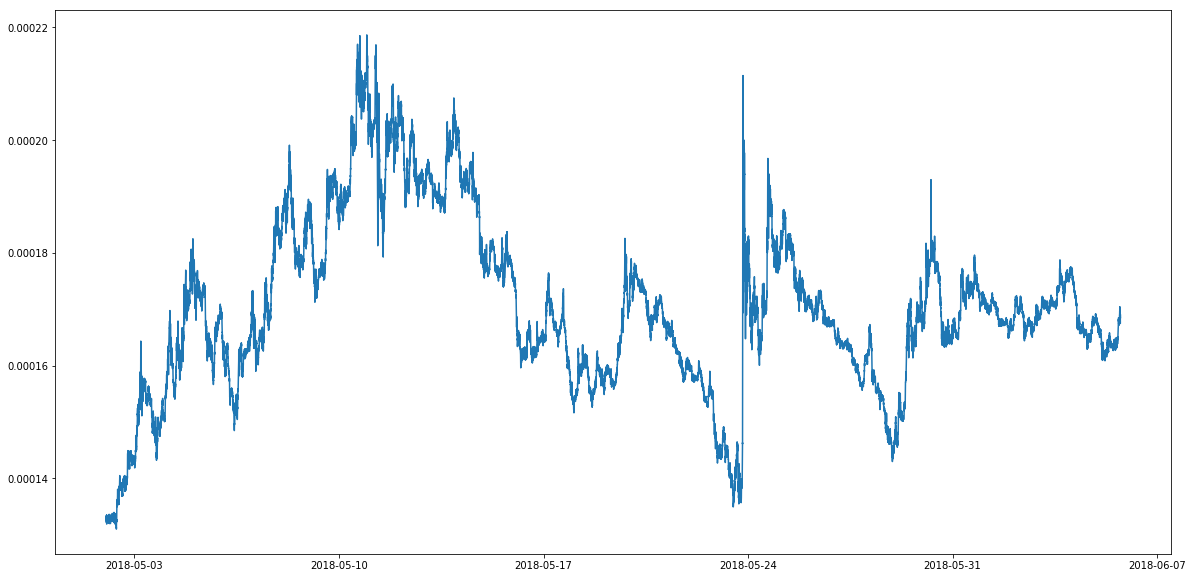

In [27]:
plt.figure(figsize=(20,10))
plt.plot(Mins,minClose)

In [29]:
X = []
window=240
for i in range(int(len(minClose)/window)):
 
    x=list(minClose[i*window:i*window+window]/minClose[i*window])
    X.append(np.array(x))
len(X),len(X[0])

(208, 240)

In [30]:
import numpy as np
np.random.seed(1)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,verbose=1,metric='correlation').fit_transform(X)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.000s...
[t-SNE] Computed neighbors for 208 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.264034
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.963390
[t-SNE] Error after 1000 iterations: 0.440072


(208, 2)

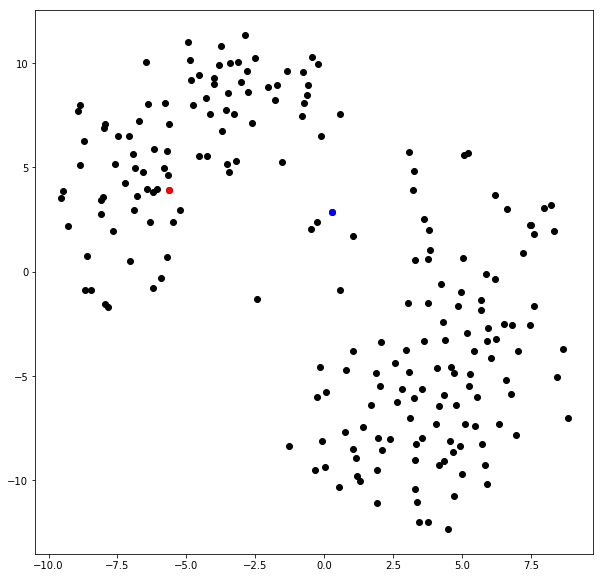

In [31]:
plt.figure(figsize=(10,10))
xx = X_embedded[:,0]
yy = X_embedded[:,1]
plt.plot(xx,yy,'ko')
plt.plot(xx[0],yy[0],'bo')
plt.plot(xx[-1],yy[-1],'ro')


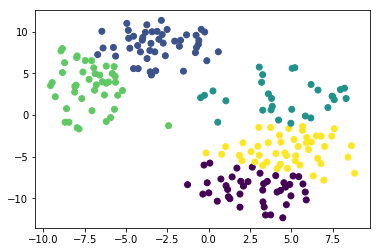

In [32]:
from sklearn.cluster import KMeans
np.random.seed(100)
kmeans = KMeans(n_clusters=5, random_state=10).fit(X_embedded)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=kmeans.labels_)

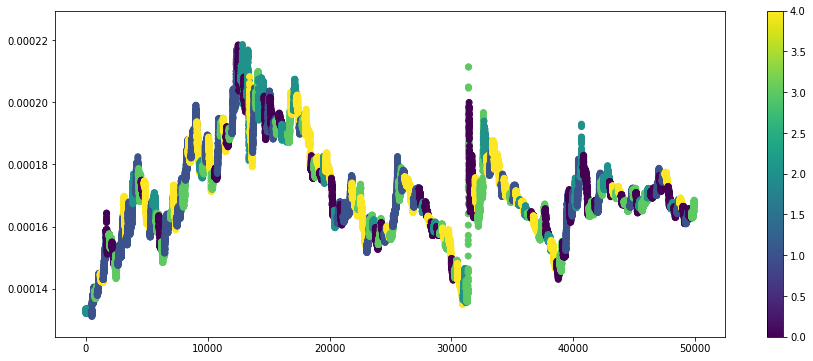

In [33]:
label = []
for i in kmeans.labels_:
    label+=[i]*window
plt.figure(figsize=(15,6))
plt.ylim((min(minClose)*0.95,max(minClose)*1.05))
plt.scatter(range(len(X_embedded)*window),minClose[:len(X_embedded)*window],c=label)
plt.colorbar()

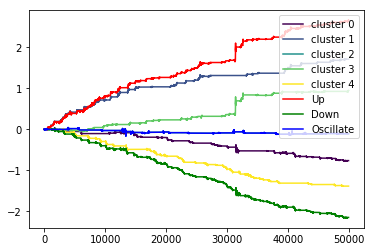

In [34]:
Seg = []
Cur = []
u = np.zeros(len(X_embedded)*window+1)
d = np.zeros(len(X_embedded)*window+1)
o = np.zeros(len(X_embedded)*window+1)
us = []
ds = []
os=  []
for j in range(5):
    cur = [0]
    seg = 0
    flag= False
    for i in range(len(X_embedded)*window):
        ret = minClose[i+1]*1.0/minClose[i]-1
        if label[i] == j:
            if not flag:
                seg+=1
                flag = True
            cur.append(cur[-1]+ret)
        else:
            if flag:
                flag=False
            cur.append(cur[-1])
    Cur.append(cur)
    Seg.append(seg)
    plt.plot(cur,c=cmap(j/4.0),label='cluster '+str(j))
Cur = np.array(Cur)
end = Cur[:,-1]
for i in range(5):
    if end[i]>=0.2*max(end):
        u+=Cur[i]
        us.append(i)
    elif end[i]<=0.2*min(end):
        d+=Cur[i]
        ds.append(i)
    else:
        o+=Cur[i]
        os.append(i)
plt.plot(u,'r',label='Up')
plt.plot(d,'g',label='Down')
plt.plot(o,'b',label='Oscillate')
plt.legend()

In [339]:
#reg_score(u,o,d),reg_score(u,o,d,method='smooth')

(43.67573278770472, 35.792011139964345)

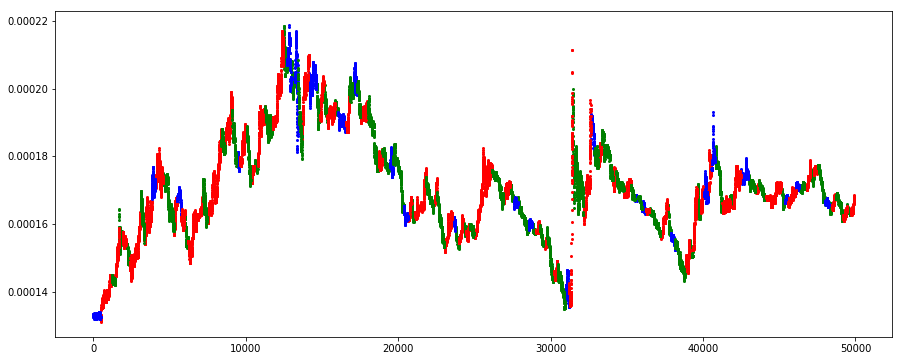

In [35]:
plt.figure(figsize=(15,6))
score_up = 0
score_down = 0
score_none = 0
tseg = sum(Seg)
fee=0.005
Mins=np.arange(len(X_embedded)*window)
Close=np.array(minClose[:len(X_embedded)*window])
Z=np.array(label)
for i in range(5):
    
    if i in os:
        score_none+=end[i]
        plt.plot(Mins[Z==i],Close[Z==i],'bo',markersize=2)
    elif i in us:
        score_up+=end[i]-fee*Seg[i]
        plt.plot(Mins[Z==i],Close[Z==i],'ro',markersize=2)
    else:
        score_down+=abs(end[i])-fee*Seg[i]
        plt.plot(Mins[Z==i],Close[Z==i],'go',markersize=2)

In [36]:
print('Score:'+str(score_up+score_down-abs(score_none)))

Score:3.950244580698988
